Two ways :
1> use othervariables to impute by training an imputation model.
2> Train two different models, one for data with N/a, other for data without N/a. and predict using the respective models. 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
import plotly

In [ ]:
!pip install catboost

     |████████████████████████████████| 67.3MB 54kB/s 


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import random
import os

from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
from catboost import CatBoostClassifier, Pool

import warnings
warnings.filterwarnings('ignore')


In [ ]:
 from google.colab import drive

drive.mount('/content/drive')

train_df = pd.read_csv('/content/drive/My Drive/jobathon/train.csv')

test_df = pd.read_csv('/content/drive/My Drive/jobathon/test.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#For Imputation

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   245725 non-null  object
 1   Gender               245725 non-null  object
 2   Age                  245725 non-null  int64 
 3   Region_Code          245725 non-null  object
 4   Occupation           245725 non-null  object
 5   Channel_Code         245725 non-null  object
 6   Vintage              245725 non-null  int64 
 7   Credit_Product       216400 non-null  object
 8   Avg_Account_Balance  245725 non-null  int64 
 9   Is_Active            245725 non-null  object
 10  Is_Lead              245725 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 20.6+ MB


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105312 entries, 0 to 105311
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   105312 non-null  object
 1   Gender               105312 non-null  object
 2   Age                  105312 non-null  int64 
 3   Region_Code          105312 non-null  object
 4   Occupation           105312 non-null  object
 5   Channel_Code         105312 non-null  object
 6   Vintage              105312 non-null  int64 
 7   Credit_Product       92790 non-null   object
 8   Avg_Account_Balance  105312 non-null  int64 
 9   Is_Active            105312 non-null  object
dtypes: int64(3), object(7)
memory usage: 8.0+ MB


In [ ]:
cols_to_remove = ['ID', 'Gender', 'Is_Lead', 'Avg_Account_Balance']
cat_columns = ['Occupation', 'Channel_Code', 'Is_Active', 'Region_Code']

target = 'Credit_Product'

_X = train_df.dropna().drop(cols_to_remove, axis=1)
_XTEST = test_df.dropna().drop([x for x in cols_to_remove if x != 'Is_Lead'] , axis=1)

X_all = pd.concat([_X, _XTEST]).reset_index(drop=True)

X_all[target][X_all[target] == 'No'] = 0
X_all[target][X_all[target] == 'Yes'] = 1
X_all[target] = X_all[target].astype('int')

X = X_all.drop(target, axis = 1)
y = X_all[target]
X, y

(        Age Region_Code     Occupation Channel_Code  Vintage Is_Active
 0        73       RG268          Other           X3       43        No
 1        30       RG277       Salaried           X1       32        No
 2        56       RG268  Self_Employed           X3       26       Yes
 3        34       RG270       Salaried           X1       19        No
 4        30       RG282       Salaried           X1       33        No
 ...     ...         ...            ...          ...      ...       ...
 309185   52       RG268       Salaried           X2       86       Yes
 309186   55       RG277          Other           X2       86        No
 309187   35       RG254       Salaried           X4       15        No
 309188   53       RG254          Other           X3       93       Yes
 309189   27       RG256       Salaried           X1       21        No
 
 [309190 rows x 6 columns], 0         0
 1         0
 2         0
 3         0
 4         0
          ..
 309185    1
 309186    1
 30

In [ ]:
LE = {}
for col in cat_columns:
    print(col)
    le = LabelEncoder()
    le.fit(X[col])
    X[col] = le.transform(X[col])
    LE[col] = le

Occupation
Channel_Code
Is_Active
Region_Code


In [ ]:
NUM_OF_BOOST_ROUND = 20000
EARLY_STOPPING = 300

In [ ]:
cat_features_index = [i for i,col in enumerate(X.columns) if col in cat_columns]
cat_features_index

[1, 2, 3, 5]

In [ ]:
SEED = 42
X_train , X_valid, y_train, y_valid = train_test_split(X,y, 
                                                       test_size=0.2, 
                                                       random_state=SEED, 
                                                       stratify=y)

In [ ]:
params = {
    'cat_features': cat_features_index,
    'eval_metric': 'AUC',
    'random_seed': SEED,
    'n_estimators': NUM_OF_BOOST_ROUND,
}

In [ ]:
bst = CatBoostClassifier(**params, early_stopping_rounds=EARLY_STOPPING)
_ = bst.fit(X_train, y_train, eval_set=(X_valid,y_valid), plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
import pickle
with open('/content/drive/My Drive/jobathon/imputing_by_catbst.pkl', 'wb') as file :
  pickle.dump(bst, file)


In [ ]:
import pickle
with open('/content/drive/My Drive/jobathon/imputing_by_catbst.pkl', 'rb') as file :
  bst = pickle.load(file)


In [ ]:
ypred_cat = bst.predict_proba(X_valid)[:,1]

In [ ]:
roc_auc_score(y_valid, ypred_cat)

0.7612953588973929

In [ ]:
ypred_cat

array([0.32708669, 0.1692401 , 0.07404106, ..., 0.15291681, 0.69420093,
       0.175206  ])

In [ ]:
f_importance_df = pd.DataFrame(bst.get_feature_importance(), columns=['importance'], index=X_valid.columns)
f_importance_df = f_importance_df.sort_values(by='importance', ascending=False)

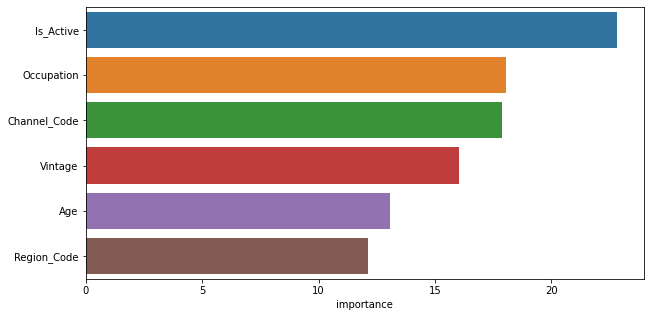

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x=f_importance_df.importance[:500], y=f_importance_df.index[:500]);

impute

In [ ]:
train_df

ID  Gender  Age  ... Avg_Account_Balance Is_Active Is_Lead
0       NNVBBKZB  Female   73  ...             1045696        No       0
1       IDD62UNG  Female   30  ...              581988        No       0
2       HD3DSEMC  Female   56  ...             1484315       Yes       0
3       BF3NC7KV    Male   34  ...              470454        No       0
4       TEASRWXV  Female   30  ...              886787        No       0
...          ...     ...  ...  ...                 ...       ...     ...
245720  BPAWWXZN    Male   51  ...             1925586        No       0
245721  HFNB7JY8    Male   27  ...              862952       Yes       0
245722  GEHAUCWT  Female   26  ...              670659        No       0
245723  GE7V8SAH  Female   28  ...              407504        No       0
245724  BOCZSWLJ    Male   29  ...             1129276        No       0

[245725 rows x 11 columns]

In [ ]:
## train
temp_df = train_df.loc[(train_df['Credit_Product'].isna())]
X = temp_df.drop(cols_to_remove + [target], axis=1)
print(X)

for cat in cat_columns:
  X[cat] = LE[cat].transform(X[cat])


cat_features_index = [i for i,col in enumerate(X.columns) if col in cat_columns]
print(cat_features_index)

ypred_cat = bst.predict(X)


indices = list(temp_df.index)

for i in range(len(indices)):
  train_df[target][indices[i]] = ypred_cat[i] 


        Age Region_Code     Occupation Channel_Code  Vintage Is_Active
6        62       RG282          Other           X3       20       Yes
15       33       RG268  Self_Employed           X2       69       Yes
31       32       RG279       Salaried           X4       15       Yes
36       41       RG268  Self_Employed           X3       62        No
40       63       RG254          Other           X3      103       Yes
...     ...         ...            ...          ...      ...       ...
245684   51       RG281   Entrepreneur           X3       99        No
245694   50       RG277  Self_Employed           X2       92        No
245699   53       RG254          Other           X2       19       Yes
245714   46       RG268  Self_Employed           X2       19        No
245720   51       RG284  Self_Employed           X3      109        No

[29325 rows x 6 columns]
[1, 2, 3, 5]


In [ ]:

## test
test_df['Avg_Account_Balance'] = test_df['Avg_Account_Balance'].astype('float')

temp_df = test_df.loc[(test_df['Credit_Product'].isna())]
X = temp_df.drop([x for x in cols_to_remove if x != 'Is_Lead'] + [target], axis=1)


for cat in cat_columns:
  X[cat] = LE[cat].transform(X[cat])

print(X)
cat_features_index = [i for i,col in enumerate(X.columns) if col in cat_columns]
print(cat_features_index)

ypred_cat = bst.predict(X)
    
indices = list(temp_df.index)

for i in range(len(indices)):
  test_df[target][indices[i]] = ypred_cat[i] 



        Age  Region_Code  Occupation  Channel_Code  Vintage  Is_Active
1        43           18           1             1       49          0
8        43           34           2             2       81          1
12       42           11           3             1       69          0
19       75           23           1             1       93          0
22       73           24           1             1       85          0
...     ...          ...         ...           ...      ...        ...
105260   45           20           2             2      117          1
105266   46            6           3             1       86          1
105272   48           18           3             1       91          1
105286   58           27           3             2       80          1
105295   46            4           3             2       74          0

[12522 rows x 6 columns]
[1, 2, 3, 5]


# Final model

In [ ]:
cols_to_remove = ['ID', "Gender", "Avg_Account_Balance"]
cat_columns = ['Occupation', 'Channel_Code', 'Credit_Product', 'Is_Active', 'Region_Code']
target = 'Is_Lead'

_X = train_df.drop(cols_to_remove + [target], axis=1)
y = train_df[target]
_XTEST = test_df.drop(cols_to_remove , axis=1)

In [ ]:
X_all = pd.concat([_X, _XTEST]).reset_index(drop=True)
X_all.shape

(351037, 7)

In [ ]:

nominal_attr = {'Gender' : 2, "Occupation" : 4, "Channel_Code": 4, "Credit_Product": 3, "Is_Active" : 2}
Gender = {"Male" : 0, "Female" : 1}
Occupation  = {"Other" : 0, "Salaried" : 1, "Self_Employed" : 2, "Entrepreneur" : 3}
Channel_Code = {"X1" : 0, "X2" : 1, "X3" : 2, "X4" : 3}
Credit_Product = {"Yes" : 0, "No" : 1, "NA" : 2}
Is_Active = {"Yes" : 0, "No" : 1}
attr_index_map = {'Gender' : Gender, "Occupation" : Occupation, "Channel_Code": Channel_Code, "Credit_Product": Credit_Product, "Is_Active" : Is_Active}

for attr in cat_columns:
  X_all[attr] = X_all[attr].astype('str')

for col in cat_columns:
    print(col)
    le = LabelEncoder()
    X_all[col] = le.fit_transform(X_all[col])

Occupation
Channel_Code
Credit_Product
Is_Active
Region_Code


In [ ]:
X = X_all[:len(y)]
XTEST = X_all[len(y):]
X.shape, XTEST.shape

((245725, 7), (105312, 7))

In [ ]:
NUM_OF_BOOST_ROUND = 10000
EARLY_STOPPING = 300

In [ ]:
cat_features_index = [i for i,col in enumerate(X.columns) if col in cat_columns]
cat_features_index

[1, 2, 3, 5, 6]

In [ ]:
SEED = 42
X_train , X_valid, y_train, y_valid = train_test_split(X,y, 
                                                       test_size=0.2, 
                                                       random_state=SEED, 
                                                       stratify=y)

In [ ]:
params = {
    'cat_features': cat_features_index,
    'eval_metric': 'AUC',
    'random_seed': SEED,
    'n_estimators': NUM_OF_BOOST_ROUND,
}

In [ ]:
bst_final_clf = CatBoostClassifier(**params, early_stopping_rounds=EARLY_STOPPING)
_ = bst_final_clf.fit(X_train, y_train, eval_set=(X_valid,y_valid), plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
ypred_cat = bst_final_clf.predict_proba(X_valid)[:,1]

In [ ]:
roc_auc_score(y_valid, ypred_cat)

0.8740585899823783

In [ ]:
f_importance_df = pd.DataFrame(bst_final_clf.get_feature_importance(), columns=['importance'], index=X_valid.columns)
f_importance_df = f_importance_df.sort_values(by='importance', ascending=False)

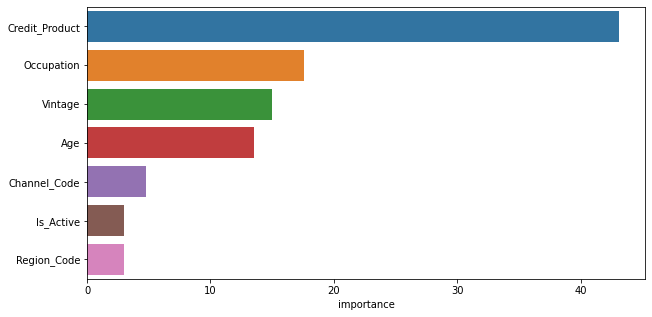

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x=f_importance_df.importance[:500], y=f_importance_df.index[:500]);

In [ ]:
ytest = bst_final_clf.predict_proba(XTEST)[:,1]

In [ ]:
ytest = np.array(ytest)
ans = np.append(np.expand_dims(test_df['ID'].to_numpy(), axis = 1) , np.expand_dims(ytest, axis = 1), axis = 1)
ans = pd.DataFrame(ans, columns = ['ID','Is_Lead'])
ans.to_csv('/content/drive/My Drive/jobathon/ans.csv', index = False)

#2


In [ ]:
 from google.colab import drive

drive.mount('/content/drive')

train_df = pd.read_csv('/content/drive/My Drive/jobathon/train.csv')

test_df = pd.read_csv('/content/drive/My Drive/jobathon/test.csv')


Mounted at /content/drive


In [ ]:
LE = {}
for col in ['Gender' , "Occupation" , "Channel_Code", "Credit_Product", "Is_Active", 'Region_Code']:
    print(col)
    le = LabelEncoder()
    le.fit(train_df.dropna()[col])
    LE[col] = le

Gender
Occupation
Channel_Code
Credit_Product
Is_Active
Region_Code


with


In [ ]:
cols_to_remove = ['ID', "Gender", "Avg_Account_Balance"]
cat_columns = ['Occupation', 'Channel_Code', 'Credit_Product', 'Is_Active', 'Region_Code']
target = 'Is_Lead'

X_with = train_df[train_df['Credit_Product'].notna()].drop(cols_to_remove + [target], axis=1)  # all examples with non null vlues of credit product


y = train_df[train_df['Credit_Product'].notna()][target]

In [ ]:
for cat in cat_columns:
    print(cat)
    X_with[cat] = LE[cat].transform(X_with[cat])
X = X_with

Occupation
Channel_Code
Credit_Product
Is_Active
Region_Code


In [ ]:
NUM_OF_BOOST_ROUND = 10000
EARLY_STOPPING = 300
cat_features_index = [i for i,col in enumerate(X.columns) if col in cat_columns]
cat_features_index
SEED = 42
X_train , X_valid, y_train, y_valid = train_test_split(X,y, 
                                                       test_size=0.2, 
                                                       random_state=SEED, 
                                                       stratify=y)
params = {
    'cat_features': cat_features_index,
    'eval_metric': 'AUC',
    'random_seed': SEED,
    'n_estimators': NUM_OF_BOOST_ROUND,
}

[1, 2, 3, 5, 6]

In [ ]:
bst_with = CatBoostClassifier(**params, early_stopping_rounds=EARLY_STOPPING)
_ = bst_with.fit(X_train, y_train, eval_set=(X_valid,y_valid), plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

without

In [ ]:
cols_to_remove = ['ID', "Gender", "Avg_Account_Balance", "Credit_Product"]
cat_columns = ['Occupation', 'Channel_Code', 'Is_Active', 'Region_Code']
target = 'Is_Lead'

X_without = train_df[train_df['Credit_Product'].isna()].drop(cols_to_remove + [target], axis=1)  # all examples with null vlues of credit product


y = train_df[train_df['Credit_Product'].isna()][target]

In [ ]:
for cat in cat_columns:
    print(cat)
    X_without[cat] = LE[cat].transform(X_without[cat])
X_without

Occupation
Channel_Code
Is_Active
Region_Code


Age  Region_Code  Occupation  Channel_Code  Vintage  Is_Active
6        62           32           1             2       20          1
15       33           18           3             1       69          1
31       32           29           2             3       15          1
36       41           18           3             2       62          0
40       63            4           1             2      103          1
...     ...          ...         ...           ...      ...        ...
245684   51           31           0             2       99          0
245694   50           27           3             1       92          0
245699   53            4           1             1       19          1
245714   46           18           3             1       19          0
245720   51           34           3             2      109          0

[29325 rows x 6 columns]

In [ ]:
y

6         1
15        1
31        1
36        1
40        1
         ..
245684    1
245694    1
245699    1
245714    1
245720    0
Name: Is_Lead, Length: 29325, dtype: int64

In [ ]:
X = X_without

In [ ]:
NUM_OF_BOOST_ROUND = 10000
EARLY_STOPPING = 300
cat_features_index = [i for i,col in enumerate(X.columns) if col in cat_columns]
cat_features_index
SEED = 42
X_train , X_valid, y_train, y_valid = train_test_split(X,y, 
                                                       test_size=0.2, 
                                                       random_state=SEED, 
                                                       stratify=y)
params = {
    'cat_features': cat_features_index,
    'eval_metric': 'AUC',
    'random_seed': SEED,
    'n_estimators': NUM_OF_BOOST_ROUND,
}

In [ ]:
bst_without = CatBoostClassifier(**params, early_stopping_rounds=EARLY_STOPPING)
bst_without.fit(X_train, y_train, eval_set=(X_valid,y_valid), plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

#test

In [ ]:
test_df['Is_Lead'] = np.nan
test_df

ID  Gender  Age  ... Avg_Account_Balance Is_Active Is_Lead
0       VBENBARO    Male   29  ...              742366        No     NaN
1       CCMEWNKY    Male   43  ...              925537        No     NaN
2       VK3KGA9M    Male   31  ...              215949        No     NaN
3       TT8RPZVC    Male   29  ...              868070        No     NaN
4       SHQZEYTZ  Female   29  ...              657087        No     NaN
...          ...     ...  ...  ...                 ...       ...     ...
105307  DBENJOYI    Male   52  ...             4242558       Yes     NaN
105308  CWQ72DWS    Male   55  ...             1159153        No     NaN
105309  HDESC8GU    Male   35  ...             1703727        No     NaN
105310  2PW4SFCA    Male   53  ...              737178       Yes     NaN
105311  F2NOYPPZ    Male   27  ...              591565        No     NaN

[105312 rows x 11 columns]

In [ ]:
# with
target = 'Is_Lead'
cols_to_remove = ['ID', "Gender", "Avg_Account_Balance"]
cat_columns = ['Occupation', 'Channel_Code', 'Credit_Product', 'Is_Active', 'Region_Code']
X_with = test_df[test_df['Credit_Product'].notna()].drop(cols_to_remove + [target], axis=1)  # all examples with non null vlues of credit product
X = X_with


for cat in cat_columns:
  X[cat] = LE[cat].transform(X[cat])


cat_features_index = [i for i,col in enumerate(X.columns) if col in cat_columns]
cat_features_index


bst = bst_with
ypred_cat = bst.predict_proba(X)[:,1]

indices = list(X.index)

for i in range(len(indices)):
  test_df[target][indices[i]] = ypred_cat[i] 



In [ ]:
#without
cols_to_remove = ['ID', "Gender", "Avg_Account_Balance", 'Credit_Product']
cat_columns = ['Occupation', 'Channel_Code',  'Is_Active', 'Region_Code']
X_without = test_df[test_df['Credit_Product'].isna()].drop(cols_to_remove + [target], axis=1)  # all examples with non null vlues of credit product
X = X_without


for cat in cat_columns:
  X[cat] = LE[cat].transform(X[cat])
print(X)

cat_features_index = [i for i,col in enumerate(X.columns) if col in cat_columns]
cat_features_index

print(cat_features_index)

bst = bst_without
ypred_cat = bst.predict_proba(X)[:,1]

indices = list(X.index)

for i in range(len(indices)):
  test_df[target][indices[i]] = ypred_cat[i] 


        Age  Region_Code  Occupation  Channel_Code  Vintage  Is_Active
1        43           18           1             1       49          0
8        43           34           2             2       81          1
12       42           11           3             1       69          0
19       75           23           1             1       93          0
22       73           24           1             1       85          0
...     ...          ...         ...           ...      ...        ...
105260   45           20           2             2      117          1
105266   46            6           3             1       86          1
105272   48           18           3             1       91          1
105286   58           27           3             2       80          1
105295   46            4           3             2       74          0

[12522 rows x 6 columns]
[1, 2, 3, 5]


In [ ]:
test_df[target].isna().sum()

0

In [ ]:
ans = test_df[['ID', target]]
ans.to_csv('/content/drive/My Drive/jobathon/ans.csv', index = False)